In [1]:
import pandas as pd
import geopandas as gpd

from shapely.geometry import Point
import matplotlib.pyplot as plt

In [2]:
dat = pd.read_excel(
    'Border_Custody_Arrest_2016-2017.xlsx',
    skipfooter=3
)

Analyses use `Report No` to aggregate violations to numbers of criminal arrests in accordance with this caveat of the information request:

> Please note that the data provided includes all violations from criminal arrests; therefore, multiple
charges can be listed for the same violator. This listing reports all violations while the chart
provided in connection with Director McCraw's testimony only includes the number of criminal
arrests.

In [3]:
'{:,} arrests'.format(len(
    dat['Report No'].unique()
))

'36,009 arrests'

In [4]:
dat.groupby('Report No')['Datetime'].first().apply(
    lambda x: x.year
).value_counts().apply(
    '{:,}'.format
).sort_index().rename(
    'Arrests by year'
)

2016    15,264
2017    20,745
Name: Arrests by year, dtype: object

In [5]:
dat.groupby('Report No')['County'].first().value_counts().apply(
    '{:,}'.format
).head(20).rename(
    'Arrests by county'
)

Hidalgo         8,256
El Paso         3,869
Cameron         2,424
Starr           1,948
Ector           1,399
Midland         1,328
San Patricio    1,211
Maverick        1,195
Webb            1,186
Nueces          1,076
Tom Green         973
Pecos             866
Val Verde         674
Aransas           594
Jim Wells         585
Hudspeth          503
Uvalde            425
Live Oak          416
Howard            408
Zapata            403
Name: Arrests by county, dtype: object

### DWI and drug/smuggling-related violations

In [6]:
drug_related = dat[
    dat['Violation Description'].str.contains(
        'DRUG|SMUGG|CONTROLLED SUBSTANCE|ASSAULT|BATTERY|WEAPON|ROBBERY'
    )
]['Violation Description'].unique()

print(
    drug_related
)

['CONTROLLED SUBSTANCE OFFENSES-MISDEMEANOR'
 'INTOXICATION ASSAULT - FELONY' 'CONTROLLED SUBSTANCE OFFENSES-FELONY'
 'POSSESSION OR DELIVERY OF DRUG PARAPHERNALIA'
 'OTHER ASSAULTIVE OFFENSES-MISDEMEANOR'
 'UNLAWFUL CARRYING WEAPONS (UCW)-MISDEMEANOR [46.05(a)(2)] '
 'ASSAULT-FELONY' 'OTHER WEAPONS OFFENSES-FELONY'
 'UNLAWFUL CARRYING WEAPONS (UCW)FELONY [46.05(a)(1,3,4,5);46.05(a)(6)] '
 'ASSAULT-MISDEMEANOR' 'SMUGGLING OF PERSONS - FELONY [20.05] '
 'UNLAWFUL CARRYING WEAPONS (UCW) - MISDEMEANOR (FEDERAL) EFFECTIVE 1/1/2000'
 'AGGRAVATED ASSAULT-FELONY' 'OTHER ASSAULTIVE OFFENSES-FELONY'
 'AGGRAVATED ASSAULT ON LAW ENFORC/CORR OFFICR,PROBATION PERSONNL-FELONY'
 'UNLAWFUL CARRYING WEAPONS (UCW) - FELONY (FEDERAL)  EFFECTIVE 1/1/2000'
 'SEXUAL ASSAULT-FELONY' 'ROBBERY-FELONY' 'AGGRAVATED ROBBERY-FELONY'
 'AGGRAVATED SEXUAL ASSAULT-FELONY' 'AGGRAVATED ASSAULT-MISDEMEANOR'
 'DRIVER HAS/USE DRUGS [392.4(a)] '
 'TAKING OR ATTEMPING TO TAKE WEAPON FROM PEACE OFFICER-FELONY'
 'SEXUAL ASSAUL

In [7]:
dwi = [
    'DRIVING UNDER THE INFLUENCE BY MINOR (UNDER 21 YEARS OF AGE)(#)',
    'DRIVING WHILE INTOXICATED-1ST OFFENSE',
    'DRIVING WHILE INTOXICATED-2ND OFFENSE',
    'DRIVING WHILE INTOXICATED-1ST OFFENSE:OPEN CONTAINER',
    'DRIVING WHILE INTOXICATED-3RD/SUBSEQUENT OFFENSE',
    'DRIVING WHILE INTOXICATED-2ND OFFENSE:WITH SERIOUS BODILY INJURY',
    'DRIVING WHILE INTOXICATED-3RD/SUB OFF:OPEN CONTAINER'
]

In [8]:
dat_drug_dwi = dat.assign(
    # For each violation, determine if it is related to drugs/smuggling or DWI
    drug_related = dat['Violation Description'].isin(drug_related),
    dwi = dat['Violation Description'].isin(dwi),
    non_dwi = dat['Violation Description'].isin(dwi) == False
).groupby('Report No')[[
    # Group violations by arrest
    'drug_related',
    'dwi',
    'non_dwi'
]].sum().applymap(
    # Did the arrest have at least one of
    # each violation category?
    lambda x: x > 0
).assign(
    # Rename values for legibility
    drug_related = lambda x: x.drug_related.replace(
        True, 'drug/smuggling'
    ).replace(
        False, 'No drug/smuggling'
    ),
    dwi = lambda x: x.dwi.replace(
        True, 'DWI'
    ).replace(
        False, 'No DWI'
    ),
    non_dwi = lambda x: x.non_dwi.replace(
        True, 'Non-DWI'
    ).replace(
        False, 'Zero non-Dwi'
    )
)

In [9]:
pd.crosstab(
    dat_drug_dwi.dwi,
    dat_drug_dwi.drug_related,
    normalize=True
).unstack().sort_values(ascending=False).apply(
    '{:.2%}'.format
).apply(pd.Series).rename(
    columns = {0: 'percent of arrests'}
)

percent of arrests
drug_related      dwi                      
drug/smuggling    No DWI             42.73%
No drug/smuggling No DWI             28.23%
                  DWI                27.84%
drug/smuggling    DWI                 1.20%

### DWI arrests by county

In [10]:
dat_dwi_county = dat.assign(
    drug_related = dat['Violation Description'].isin(drug_related),
    dwi = dat['Violation Description'].isin(dwi),
    non_dwi = dat['Violation Description'].isin(dwi) == False
).groupby('Report No')[[
    'drug_related',
    'dwi',
    'non_dwi',
    'County'
]].agg({
    'drug_related': sum,
    'dwi': sum,
    'non_dwi': sum,
    'County': pd.Series.mode
}).query(
    # Get arrests that had a DWI violation
    # and no drugs/smuggling-related violations
    'dwi == 1 & drug_related == 0 & non_dwi == 0'
).groupby(
    'County'
).dwi.sum()

In [11]:
dat_dwi_county.loc[[
    # Midland-Odessa
    'Ector',
    'Midland',
    'Martin',
    # Hill Country
    'Kimble',
    'Mason',
    'McCulloch',
    'Menard',
]].sort_values(
    ascending=False
).rename(
    'DWI arrests in Midland-Odessa metro and Hill Country'
).astype(int)

County
Ector        364
Midland      265
Martin        32
McCulloch     28
Kimble        22
Mason         12
Menard         6
Name: DWI arrests in Midland-Odessa metro and Hill Country, dtype: int64

### Arrests within 100 miles of US-Mexico border

**Note:** not all arrest records have latitude and longitude

In [12]:
# Create a GeoDataFrame

dat_geo = gpd.GeoDataFrame(
    dat.replace('--', pd.np.nan).assign(
        geometry = lambda x: x[['Latitude', 'Longitude']].apply(
            # Only make a point if both Latitude and Longitude are available
            lambda x: pd.np.nan if pd.np.isnan(x[1]) or pd.np.isnan(x[0])else Point(x[1], x[0]), axis=1
        )
    ).assign(
        is_point = lambda x: x.geometry.isnull() == False
    ).query(
        # Only include valid Latitude/Longitude points
        'is_point'
    ).drop('is_point', axis=1)
)

dat_geo.crs = {'init' :'epsg:4326'}

In [13]:
print(
    '{:,} ({:.1%}) geocoded arrests'.format(
        len(dat_geo['Report No'].unique()),
        
        len(dat_geo['Report No'].unique()) / len(
            dat['Report No'].unique()
        )
    )
)


29,099 (80.8%) geocoded arrests


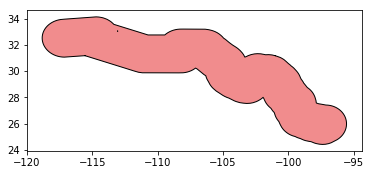

In [14]:
# Download Natural Earth boundary lines
# https://www.naturalearthdata.com/downloads/10m-cultural-vectors/
dat_border = gpd.read_file(
    'ne_10m_admin_0_boundary_lines_land/ne_10m_admin_0_boundary_lines_land.shp'
).query(
    # Isolate US-Mexico border
    'adm0_abr_r == "U.S.A." & adm0_left == "Mexico"'
)

# Create a 100-mile buffer around US-Mexico border
dat_border_100 = dat_border.to_crs({
    'init': 'epsg:3663'
}).buffer(
    100 * 1609.34
    # Projection is in meters
    # Generate 100-mile buffer with 1609.34 meters per mile
).to_crs({
    'init': 'epsg:4326'
})

dat_border_100.plot()

plt.show()

In [15]:
dat_geo.assign(
    within_border_100 = lambda x: x.geometry.within(dat_border_100.iloc[0]),
).groupby('Report No').within_border_100.sum().apply(
    lambda x: x > 0
).value_counts(normalize=True).apply(
    '{:.2%}'.format
).rename({
    True: 'Within 100 miles',
    False: 'Beyond 100 miles'
}).apply(pd.Series).rename(
    columns = {0: ''}
)

,
Within 100 miles,73.22%
Beyond 100 miles,26.78%
